In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Extracting EDF parameters from /content/drive/My Drive/ML/edf_t1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


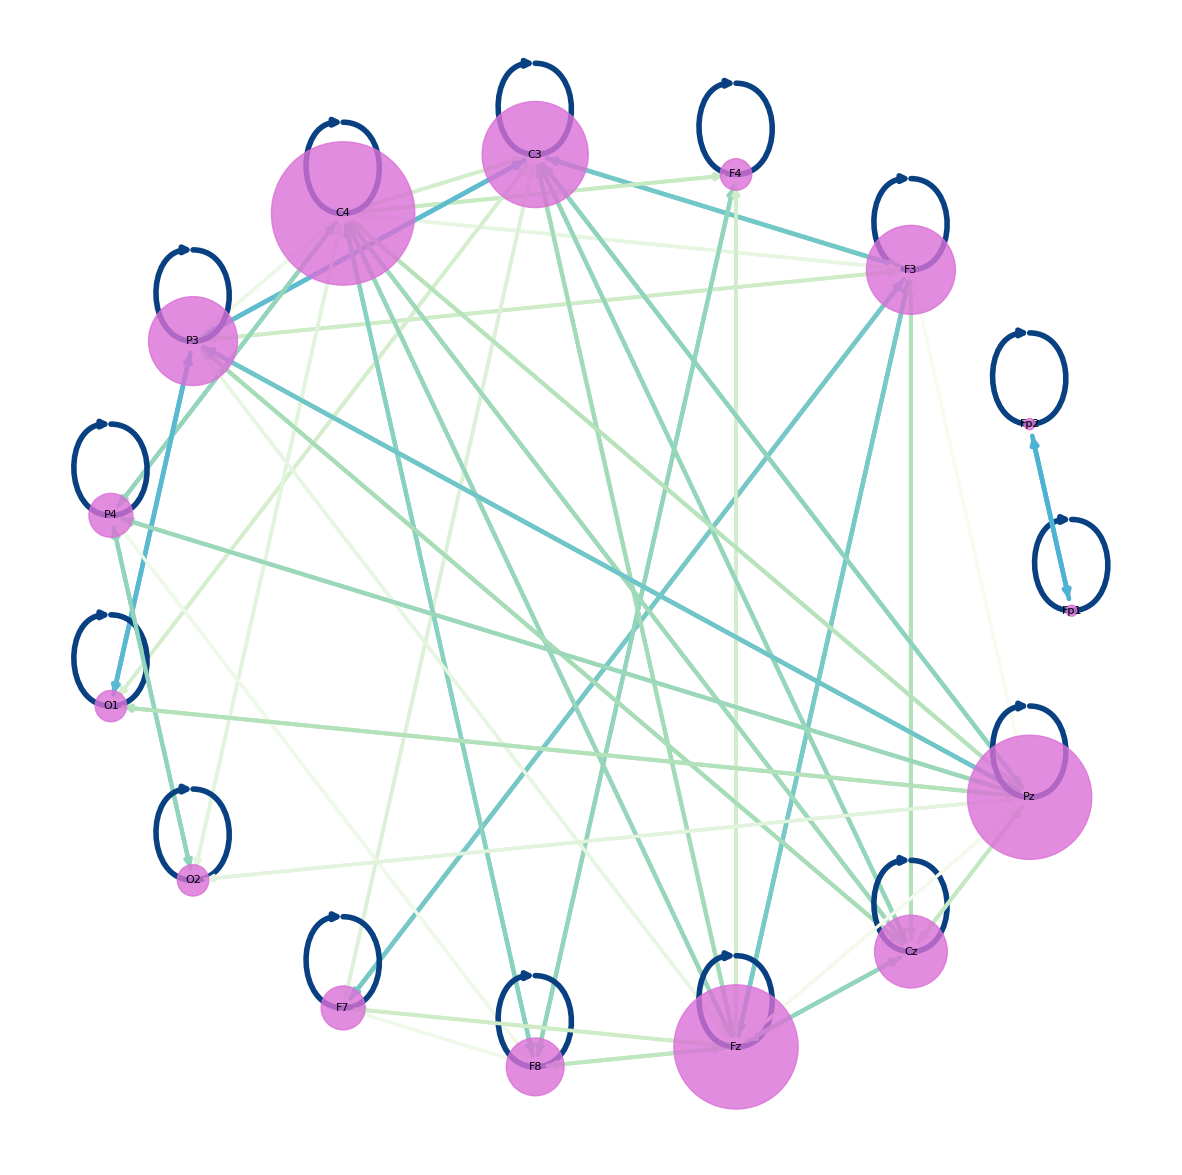

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os.path as op
import mne


data_path = '/content/drive/My Drive/ML/'

raw_fname = op.join(data_path, "edf_t1.edf")

final_event_fname = op.join(data_path, "events.txt")


raw = mne.io.read_raw_edf(raw_fname)
data = raw.get_data()
data = np.transpose(data)
df = pd.DataFrame(data, columns=raw.ch_names)

# Should we remove the first column?
cor_matrix = df.corr()

#extracts the indices from the correlation matrix, which are the channels
channel_names = cor_matrix.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix = np.asmatrix(cor_matrix)

#Creates graph using the data of the correlation matrix
G = nx.DiGraph(cor_matrix)

#relabels the nodes to match the  channels names
G = nx.relabel_nodes(G,lambda x: channel_names[x])


def create_corr_network_graph(G, corr_direction, threshold_correlation_value):
    #shows the edges with their corresponding edge data
    edges_with_weights = G.edges(data=True)
    ##Creates a copy of the graph
    G_copy = G.copy()

    ##Checks all the edges and removes some based on corr_direction
    for node_1, node_2, edge_data in edges_with_weights:
        ##if we only want to see the positive correlations, we delete the edges with weight smaller than 0
        if corr_direction == "positive":
            min_correlation_value = max(threshold_correlation_value, 0)
            if edge_data["weight"] < min_correlation_value:
                G_copy.remove_edge(node_1, node_2)
        ##if the corr_direction is negative, remove edges with weights equal to or larger than 0
        else:
            max_correlation_value = min(-1, threshold_correlation_value)
            if edge_data["weight"] > max_correlation_value:
                G_copy.remove_edge(node_1, node_2)

    #returns the edges and their corresponding weights separately
    edges, weights = zip(*nx.get_edge_attributes(G_copy,'weight').items())

    #computes the positions of the nodes in a circular layout
    circular_positions = nx.circular_layout(G_copy)

    #Figure size
    plt.figure(figsize=(15,15))

    #returns the degree of each node as a list of tuples (label, degree)
    node_labels_and_degrees = nx.degree(G_copy)
    #Returns node labels and their corresponding degrees separately, will be used later for their sizes
    node_labels, node_degrees = zip(*node_labels_and_degrees)

    #draws nodes
    nx.draw_networkx_nodes(G_copy, circular_positions, node_color='#DA70D6', nodelist=node_labels,
                        ##### Higher degree nodes have bigger size
                        node_size=tuple([x**3 for x in node_degrees]),alpha=0.8)

    #Styling for labels
    nx.draw_networkx_labels(G_copy, circular_positions, font_size=8,
                            font_family='sans-serif')
    ### increases the value of weights, so that they are more visible in the graph
    weights = tuple([(1 + abs(x))**2 for x in weights])

    ###edge colors based on weight direction
    if corr_direction == "positive":
        edge_colour = plt.cm.GnBu
    else:
        edge_colour = plt.cm.PuRd

    #draws the edges
    nx.draw_networkx_edges(G_copy, circular_positions, edgelist=edges, style='solid',
                      ###adds width=weights and edge_color = weights
                      ###so that edges are based on the weight parameter
                      ###edge_cmap is for the color scale based on the weight
                      ### edge_vmin and edge_vmax assign the min and max weights for the width
                      width=weights, edge_color=weights, edge_cmap=edge_colour,
                      edge_vmin=min(weights), edge_vmax=max(weights))

    # displays the graph without axis
    plt.axis('off')
    #saves image
    plt.savefig("part1.png", format="PNG")
    plt.show()
    return G_copy

G = create_corr_network_graph(G, "positive", 0.5)

In [11]:
degreeCentrality = nx.degree_centrality(G)

print("Degree Centrality", degreeCentrality)

betweennessCentrality = nx.betweenness_centrality(G)

print("Betweenness Centrality", betweennessCentrality)

Degree Centrality {'Fp1': 0.2857142857142857, 'Fp2': 0.2857142857142857, 'F3': 1.1428571428571428, 'F4': 0.5714285714285714, 'C3': 1.2857142857142856, 'C4': 1.5714285714285714, 'P3': 1.1428571428571428, 'P4': 0.7142857142857142, 'O1': 0.5714285714285714, 'O2': 0.5714285714285714, 'F7': 0.7142857142857142, 'F8': 0.8571428571428571, 'Fz': 1.4285714285714284, 'Cz': 1.0, 'Pz': 1.4285714285714284}
Betweenness Centrality {'Fp1': 0.0, 'Fp2': 0.0, 'F3': 0.016483516483516484, 'F4': 0.0, 'C3': 0.04990842490842492, 'C4': 0.13965201465201466, 'P3': 0.021062271062271064, 'P4': 0.011904761904761904, 'O1': 0.0, 'O2': 0.0, 'F7': 0.0086996336996337, 'F8': 0.031135531135531136, 'Fz': 0.08104395604395603, 'Cz': 0.0, 'Pz': 0.10164835164835166}
